# Welcome to the notebook that trains the model to extract rod positions and angles

Welcome to foosbot

In [1]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python

In [1]:
from __future__ import print_function


from video_file import *

import importlib
try:
    importlib.reload(video_file)
except:
    pass

import cv2
import sys
import os
import csv
import numpy as np
from random import randint
from random import shuffle

from PIL import Image
import imageio
import itertools as it

import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)


# Create the image transformer
transformer = VideoTransform( zoom_range=0.1, rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [0], data_format='channels_last' )


# Paths relative to current python file.
data_path  = ".\\..\\..\\TrainingData\\Processed\\RodTrainingData\\Result\\settings.tsv"

Using TensorFlow backend.


Keras version 2.0.4
Tensorflow version 1.1.0


In [2]:
print("Opening training frames from config %s." % (data_path))

position_rel_indexes = [0]
frame_rel_indexes = [0]

training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2)


Opening training frames from config .\..\..\TrainingData\Processed\RodTrainingData\Result\settings.tsv.
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingData\Result\chunk0.avi
.\..\..\TrainingData\Processed\RodTrainingData\Result\chunk0.avi
added 3054 new frames for a total of 3054
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingData\Result\chunk1.avi
.\..\..\TrainingData\Processed\RodTrainingData\Result\chunk1.avi
added 4401 new frames for a total of 7455
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingData\Result\chunk2.avi
.\..\..\TrainingData\Processed\RodTrainingData\Result\chunk2.avi
added 4500 new frames for a total of 11955
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingData\Result\chunk3.avi
.\..\..\TrainingData\Processed\RodTrainingData\Result\chunk3.avi
added 4405 new frames for a total of 16360
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingData\Result\chunk4.

In [3]:
# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g



# Define our training and validation iterators
@threadsafe_generator
def TrainGen(model, training):
    while True:
        #print("TrainGen restarting training input.")
        model.reset_states()
        training.move_first_training_frame()
        (frames, output, reset_memory) = training.get_next_training_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output, reset_memory) = training.get_next_training_frame()
            
            if reset_memory or frames is None:
                model.reset_states()
                
@threadsafe_generator
def ValidateGen(model, training):
    while True:
        #print("Validation restarting training input.")
        model.reset_states()
        training.move_first_validation_frame()
        (frames, output, reset_memory) = training.get_next_validation_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output, reset_memory) = training.get_next_validation_frame()
            
            if reset_memory or frames is None:
                model.reset_states()

# Generators for training the position
@threadsafe_generator
def TrainBatchGen(batch_size, model, training):
    gen = TrainGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 1), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0] # Train just the 3 current rod positions as outputs
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

@threadsafe_generator
def ValidateBatchGen(batch_size, model, training):
    gen = ValidateGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 1), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0] # Train just the 3 current rod positions as outputs
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
        
        
    
# Helper function to plot our validation result
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline


def plot_validate(generator, model, count, name):
    #plot_validate(ValidateBatchGen(batch_size, model), model, 2000, "Position prediction")
    
    outputs_predicted = None
    outputs_true = None
    
    while outputs_predicted is None or outputs_predicted.shape[0] < count:
        
        (new_frames, new_outputs_true) = next(generator)
        if outputs_true is None:
            outputs_true = new_outputs_true
        else:
            outputs_true = np.concatenate( (outputs_true, new_outputs_true), axis=0 )
        
        
        new_outputs_predicted = model.predict(new_frames, batch_size=new_frames.shape[0], verbose=0)
        if outputs_predicted is None:
            outputs_predicted = new_outputs_predicted
        else:
            outputs_predicted = np.concatenate( (outputs_predicted, new_outputs_predicted), axis=0 )
    
    #(frames, outputs_true) = next(ValidateBatchGen(2000))
    #frames = np.squeeze(frames, axis=(1,))
    #validate_in, validate_out
    #frames = validate_in
    #outputs_true =validate_out
    
    print("Predicted.")
    
    
    pp.pprint(outputs_true)
    pp.pprint(outputs_predicted)
    
    
    #plt.figure(figsize=(8,30))
    plt.figure()
    
    #plt.subplot(111)
    plt.plot(range(count),outputs_true[0:count,0], range(count),outputs_predicted[0:count,0] )
    plt.ylabel("Rod 1: %s" % name)
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    
    
    
    #plt.figure(figsize=(8,30))
    #plt.subplot(111)
    plt.figure()
    
    true, predicted = zip(*sorted(zip(outputs_true[0:count,0], outputs_predicted[0:count,0])))
    plt.plot(range(count),true, range(count),predicted )
    plt.ylabel("Rod 1: %s" % name)
    plt.title("First 200 output recordings")
    plt.grid(True)

    
    
    plt.show()
          


# Input training frame

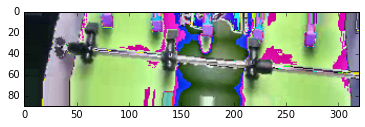

[0.5]


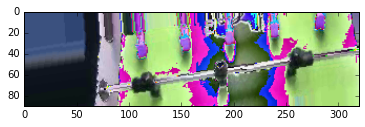

[0.0]


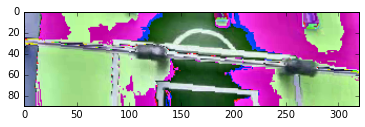

[0.0]


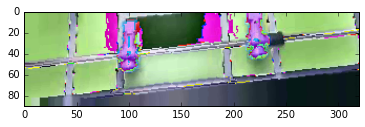

[0.5]


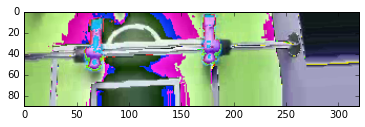

[0.5]


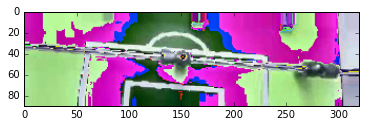

[0.0]


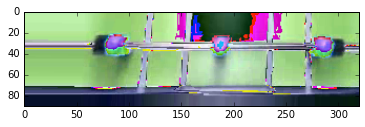

[0.0]


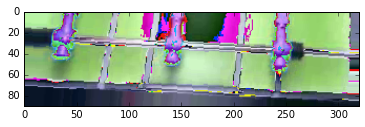

[0.5]


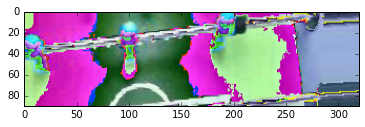

[0.0]


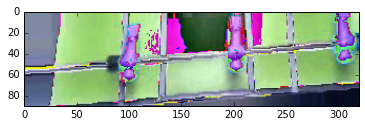

[0.5]
Shape of training input:
(1, 90, 320, 3)
Shape of training output:
(1,)
Corresponding Positions:
[0.5]


In [19]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline

#training.move_first_training_frame()

for k in range(10):
    (frame, position, reset) = training.get_next_training_frame()
    data = np.zeros(shape=(np.shape(frame)[1], np.shape(frame)[2] * np.shape(frame)[0], 3), dtype=np.float32)
    for i in range(np.shape(frame)[0]):
        tmp = frame[i,:,:,:]
        data[:,i*np.shape(frame)[2]:(i+1)*np.shape(frame)[2],:] = tmp


    plt.imshow(data)
    plt.show()
    pp.pprint(position)

#training.move_first_training_frame()

print("Shape of training input:")
pp.pprint(np.shape(frame))

print("Shape of training output:")
pp.pprint(np.shape(position))

print("Corresponding Positions:")
pd.DataFrame(position)
pp.pprint(position)




# Specify the model structure we will use

In [6]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model


number_of_frames = 1
image_height       = training.height
image_width        = training.width
image_depth        = training.depth
image_channels     = training.channels
output_size        = 1

# Model options
batch_size = 10
cnn_kernel_count = 120

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_depth, image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

 # (?, 1, 90, 320, cnn_kernel_count, 3 )
# Build a functional model design
inputs = Input(shape=(number_of_frames, image_height, image_width, image_channels,),
               batch_shape=(batch_size, number_of_frames, image_height, image_width, image_channels),
              name="Input")
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 45, 150, cnn_kernel_count, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling3D( pool_size=(1, 1, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 45, 75, 128, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x)
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x)
pool_num+=1



x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 1, 2),
                  name = "max_pooling3d_%i"%pool_num)(x)
pool_num+=1


x = Flatten()(x)

x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
predictions = Dense(output_size, activation='linear',name="dense_%i"%dense_num)(x)
dense_num+=1

model = Model(inputs=inputs, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
              loss='mean_squared_error',
              metrics=['accuracy'])


model.summary()


'Input shape without batches:'
(1, 90, 320, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (10, 1, 90, 320, 3)       0         
_________________________________________________________________
conv3d_0 (Conv3D)            (10, 1, 90, 320, 120)     3360      
_________________________________________________________________
conv3d_1 (Conv3D)            (10, 1, 90, 320, 120)     129720    
_________________________________________________________________
max_pooling3d_0 (MaxPooling3 (10, 1, 45, 160, 120)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (10, 1, 45, 160, 120)     129720    
_________________________________________________________________
conv3d_3 (Conv3D)            (10, 1, 45, 160, 120)     129720    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 

# Train our model to identify the rod positions

In [7]:


def mse(y_true, y_pred):
    return K.square(y_pred - y_true)*0.001 # Hackjob so Keras iterations show exponential value of MSE to get precision.


model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0005),
              loss='mean_squared_error',
              metrics=[mse])

print("Updated learner.")

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = '.\\RodAngle\\pos_cnn_weights_%i.hdf'
MODELS_FNAME = '.\\RodAngle\\pos_cnn_models_%i.h5'


batches_training_per_epoch = int(training.get_training_count() / batch_size)
batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )

model.reset_states()
for epoch in range(10000):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        break
    

Updated learner.
Batch size 10: 3900 training batches, 975 validation batches
Epoch 1/1
3900/3900 [==============================] - 2119s - loss: 0.0604 - mse: 6.0406e-05 - val_loss: 0.1081 - val_mse: 1.0807e-04
Wrote model to .\RodAngle\pos_cnn_weights_0.hdf
Epoch 2/2
3900/3900 [==============================] - 2103s - loss: 0.0196 - mse: 1.9590e-05 - val_loss: 0.1151 - val_mse: 1.1508e-04
Wrote model to .\RodAngle\pos_cnn_weights_1.hdf
Epoch 3/3
3900/3900 [==============================] - 2102s - loss: 0.0160 - mse: 1.6013e-05 - val_loss: 0.1139 - val_mse: 1.1389e-04
Wrote model to .\RodAngle\pos_cnn_weights_2.hdf
Epoch 4/4
3900/3900 [==============================] - 2103s - loss: 0.0142 - mse: 1.4235e-05 - val_loss: 0.0884 - val_mse: 8.8446e-05
Wrote model to .\RodAngle\pos_cnn_weights_3.hdf
Epoch 5/5
3900/3900 [==============================] - 2103s - loss: 0.0170 - mse: 1.6985e-05 - val_loss: 0.1020 - val_mse: 1.0197e-04
Wrote model to .\RodAngle\pos_cnn_weights_4.hdf
Epoch 6

# Test the best trained model's ability to extract the rod positions

In [12]:

# Load the best model result
epoch = 13
WEIGHTS_FNAME = '.\\RodAngle\\pos_cnn_weights_%i.hdf'
MODELS_FNAME = '.\\RodAngle\\pos_cnn_models_%i.h5'
model.load_weights(WEIGHTS_FNAME % epoch, by_name=True)
print("Loaded model.")



Loaded model.


Predicted.
array([[ 0.25945947],
       [ 0.25945947],
       [ 0.28648648],
       ..., 
       [ 0.91666669],
       [ 0.89705884],
       [ 0.89215684]], dtype=float32)
array([[ 0.36889505],
       [ 0.33275491],
       [ 0.38173857],
       ..., 
       [ 0.68189257],
       [ 0.67548656],
       [ 0.66991365]], dtype=float32)


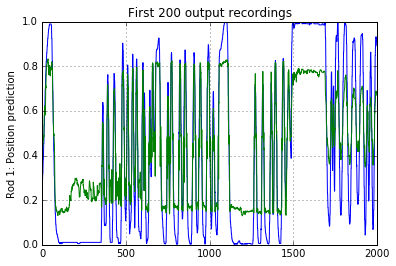

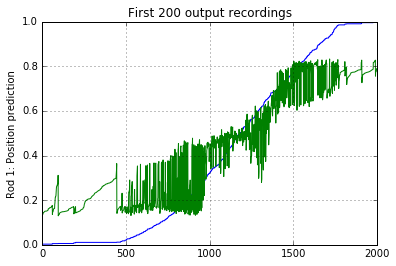

In [13]:
# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Position prediction")

In [20]:



def mse(y_true, y_pred):
    return K.square(y_pred - y_true)*0.001 # Hackjob so Keras iterations show exponential value of MSE to get precision.


model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00005),
              loss='mean_squared_error',
              metrics=[mse])

print("Updated learner.")

batches_training_per_epoch = int(training.get_training_count() / batch_size)
batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )

start_epoch = epoch
model.reset_states()
for epoch in range(start_epoch,10000):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        break

Updated learner.
Batch size 10: 1199 training batches, 299 validation batches
Epoch 1/1
   1/1199 [..............................] - ETA: 2347s - loss: 0.1177 - mse: 1.1772e-04
User stopped the training.


Predicted.
array([[ 0.25945947],
       [ 0.25945947],
       [ 0.28648648],
       ..., 
       [ 0.91666669],
       [ 0.89705884],
       [ 0.89215684]], dtype=float32)
array([[ 0.32116389],
       [ 0.32118678],
       [ 0.33413178],
       ..., 
       [ 0.90547734],
       [ 0.85345852],
       [ 0.85565698]], dtype=float32)


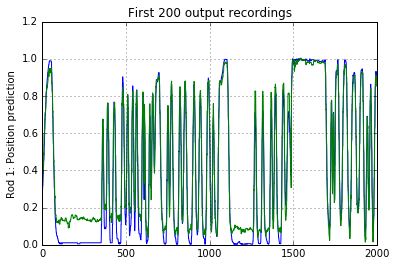

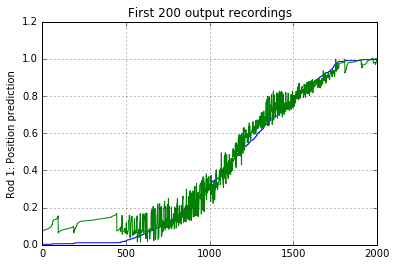

In [11]:
# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Position prediction")

In [8]:
# Load the best model result
epoch = 24
WEIGHTS_FNAME = '.\\RodAngle\\pos_cnn_weights_%i.hdf'
MODELS_FNAME = '.\\RodAngle\\pos_cnn_models_%i.h5'
model.load_weights(WEIGHTS_FNAME % epoch, by_name=True)
print("Loaded model.")

Loaded model.


In [9]:
def mse(y_true, y_pred):
    return K.square(y_pred - y_true)*0.001 # Hackjob so Keras iterations show exponential value of MSE to get precision.


model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00001),
              loss='mean_squared_error',
              metrics=[mse])

print("Updated learner.")

batches_training_per_epoch = int(training.get_training_count() / batch_size)
batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )

start_epoch = epoch
model.reset_states()
for epoch in range(start_epoch,10000):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        break

Updated learner.
Batch size 10: 3900 training batches, 975 validation batches
Epoch 25/25
3900/3900 [==============================] - 1780s - loss: 0.0068 - mse: 6.8101e-06 - val_loss: 0.0050 - val_mse: 5.0152e-06
Wrote model to .\RodAngle\pos_cnn_weights_24.hdf
Epoch 26/26
3900/3900 [==============================] - 1770s - loss: 0.0066 - mse: 6.5850e-06 - val_loss: 0.0043 - val_mse: 4.3282e-06
Wrote model to .\RodAngle\pos_cnn_weights_25.hdf
Epoch 27/27
 740/3900 [====>.........................] - ETA: 1314s - loss: 0.0077 - mse: 7.6595e-06
User stopped the training.


In [ ]:
# Load the best model result
epoch = 25
WEIGHTS_FNAME = '.\\RodAngle\\pos_cnn_weights_%i.hdf'
MODELS_FNAME = '.\\RodAngle\\pos_cnn_models_%i.h5'
model.load_weights(WEIGHTS_FNAME % epoch, by_name=True)
print("Loaded model.")

# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Position prediction")

Loaded model.


# Transfer the model as a base to predict the rod angles


In [5]:
# Paths relative to current python file.


print("Opening training frames from config %s." % (data_path))

position_rel_indexes = [0]
frame_rel_indexes = [0]

# Create the image transformer
data_path  = ".\\..\\..\\TrainingData\\Processed\\RodTrainingDataAngles\\Result\\settings_just_two.tsv"
transformer = VideoTransform( zoom_range=0.1, rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [], data_format='channels_last' )
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2)


Opening training frames from config .\..\..\TrainingData\Processed\RodTrainingData\Result\settings.tsv.
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
added 3204 new frames for a total of 3204
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
added 1667 new frames for a total of 4871


In [5]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model


number_of_frames = 1
image_height       = training.height
image_width        = training.width
image_depth        = training.depth
image_channels     = training.channels
output_size        = 1

# Model options
batch_size = 1
cnn_kernel_count = 120

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_depth, image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

 # (?, 1, 90, 320, cnn_kernel_count, 3 )
# Build a functional model design
# Build a functional model design
inputs = Input(shape=(number_of_frames, image_height, image_width, image_channels,),
               batch_shape=(batch_size, number_of_frames, image_height, image_width, image_channels),
              name="Input")
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 45, 150, cnn_kernel_count, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling3D( pool_size=(1, 1, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 45, 75, 128, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x)
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x)
pool_num+=1


x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x)
pool_num+=1


x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 1, 2),
                  name = "max_pooling3d_%i"%pool_num)(x)
pool_num+=1


x = Flatten()(x)

x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
predictions = Dense(output_size, activation='linear',name="dense_%i"%dense_num)(x)
dense_num+=1

model = Model(inputs=inputs, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
              loss='mean_squared_error',
              metrics=['accuracy'])


model.summary()


'Input shape without batches:'
(1, 90, 320, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (1, 1, 90, 320, 3)        0         
_________________________________________________________________
conv3d_0 (Conv3D)            (1, 1, 90, 320, 120)      3360      
_________________________________________________________________
conv3d_1 (Conv3D)            (1, 1, 90, 320, 120)      129720    
_________________________________________________________________
max_pooling3d_0 (MaxPooling3 (1, 1, 45, 160, 120)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (1, 1, 45, 160, 120)      129720    
_________________________________________________________________
conv3d_3 (Conv3D)            (1, 1, 45, 160, 120)      129720    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 

Updated learner.
Batch size 1: 3897 training batches, 974 validation batches
Updated learner.
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
added 3204 new frames for a total of 3204
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
added 1667 new frames for a total of 4871
Updated lr to 0.000100
Epoch 2/2
3897/3897 [==============================] - 272s - loss: 0.0441 - mse: 0.0453 - val_loss: 0.0014 - val_mse: 0.0014
Wrote model to .\RodAngle\angle_weights_1.hdf
Epoch 3/3
3897/3897 [==============================] - 274s - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0045 - val_mse: 0.0045
Wrote model to .\RodAngle\angle_weights_2.hdf
Epoch 4/4
3897/3897 [==============================] - 274s - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0019 - val

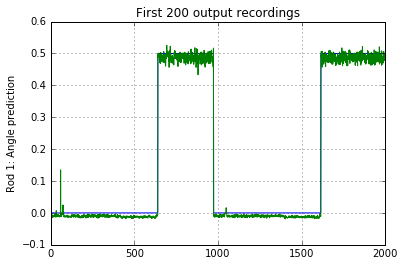

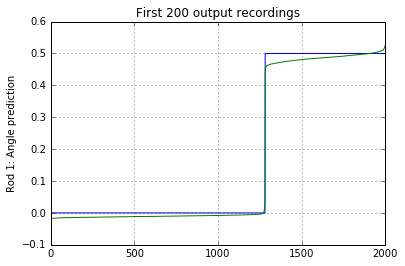

Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
added 3204 new frames for a total of 3204
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
added 1667 new frames for a total of 4871
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk4.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk4.avi
added 1172 new frames for a total of 6043
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk5.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk5.avi
added 2190 new frames for a total of 8233
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk6.avi
.\..\..\TrainingData\Processed\RodTrainingDataAn

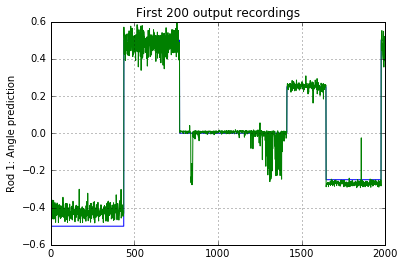

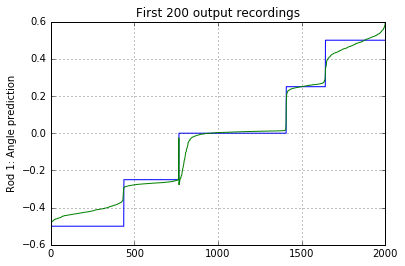

Updated lr to 0.000010
Epoch 21/21
3897/3897 [==============================] - 257s - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0038 - val_mse: 0.0038
Wrote model to .\RodAngle\angle_weights_20.hdf
Epoch 22/22
3897/3897 [==============================] - 256s - loss: 0.0102 - mse: 0.0102 - val_loss: 2.3554e-04 - val_mse: 2.3554e-04
Wrote model to .\RodAngle\angle_weights_21.hdf
Epoch 23/23
3897/3897 [==============================] - 256s - loss: 0.0107 - mse: 0.0107 - val_loss: 1.9943e-04 - val_mse: 1.9943e-04
Wrote model to .\RodAngle\angle_weights_22.hdf
Epoch 24/24
3897/3897 [==============================] - 256s - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0018 - val_mse: 0.0018
Wrote model to .\RodAngle\angle_weights_23.hdf
Epoch 25/25
3897/3897 [==============================] - 256s - loss: 0.0109 - mse: 0.0109 - val_loss: 4.6945e-04 - val_mse: 4.6945e-04
Wrote model to .\RodAngle\angle_weights_24.hdf
Epoch 26/26
3897/3897 [==============================] - 256s - loss: 0.0105 -

AssertionError: 

In [12]:


def mse_wrap(y_true, y_pred):
    # This is a rapped MSE function, since -1 is the same as 1 for rod rotation.
    return K.square( K.min( K.abs( K.concatenate([y_pred - y_true, y_pred - y_true + 2, y_pred - y_true -2])), axis=1 ) )

def mse(y_true, y_pred):
    return K.square(y_pred - y_true)


model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001),
              loss=[mse],
              metrics=[mse])

print("Updated learner.")

WEIGHTS_FNAME = '.\\RodAngle\\angle_weights_%i.hdf'
MODELS_FNAME = '.\\RodAngle\\angle_models_%i.h5'

batches_training_per_epoch = int(training.get_training_count() / batch_size)
batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )

epoch = 0
model.reset_states()

model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00001),
              loss=[mse_wrap],
              metrics=[mse])
print("Updated learner.")



# Create the image transformer
data_path  = ".\\..\\..\\TrainingData\\Processed\\RodTrainingDataAngles\\Result\\settings_just_two.tsv"
transformer = VideoTransform( zoom_range=0.1, rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [], data_format='channels_last' )
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2)
lr = 0.0001
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,5):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break
        
# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")       


data_path  = ".\\..\\..\\TrainingData\\Processed\\RodTrainingDataAngles\\Result\\settings.tsv"
transformer = VideoTransform( zoom_range=0.1, rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [], data_format='channels_last' )
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2)

lr = 0.0001
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,20):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break

# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")        

lr = 0.00001
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,40):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break


# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")

lr = 0.000001
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,60):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break


# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")
        
lr = 0.0000001
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,90):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break


# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")

lr = 0.00000001
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,120):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break 

Predicted.
array([[ 0.  ],
       [ 0.  ],
       [ 0.  ],
       ..., 
       [-0.25],
       [-0.25],
       [-0.25]], dtype=float32)
array([[ 0.00430454],
       [ 0.0032889 ],
       [ 0.00440927],
       ..., 
       [-0.22995049],
       [-0.22813967],
       [-0.22288063]], dtype=float32)


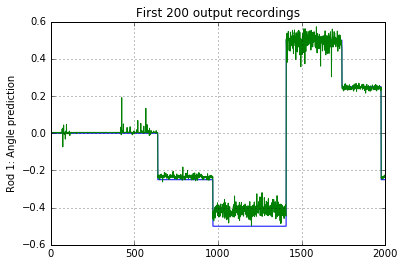

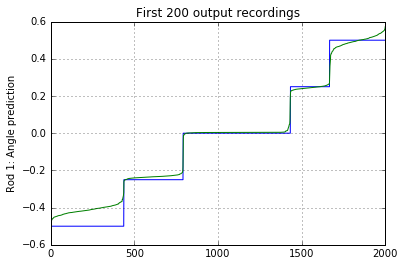

In [13]:
# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")

Updated lr to 0.000100
Epoch 33/33
3897/3897 [==============================] - 307s - loss: 0.0196 - mse: 0.0262 - val_loss: 0.0075 - val_mse: 0.0075
Wrote model to .\RodAngle\angle_weights_32.hdf
Epoch 34/34
3897/3897 [==============================] - 265s - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0150 - val_mse: 0.0150
Wrote model to .\RodAngle\angle_weights_33.hdf
Epoch 35/35
3897/3897 [==============================] - 258s - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0045 - val_mse: 0.0045
Wrote model to .\RodAngle\angle_weights_34.hdf
Epoch 36/36
3897/3897 [==============================] - 259s - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0034 - val_mse: 0.0034
Wrote model to .\RodAngle\angle_weights_35.hdf
Epoch 37/37
3897/3897 [==============================] - 258s - loss: 0.0148 - mse: 0.0148 - val_loss: 1.7341e-04 - val_mse: 1.7341e-04
Wrote model to .\RodAngle\angle_weights_36.hdf
Epoch 38/38
3897/3897 [==============================] - 258s - loss: 0.0137 - mse: 0.0137 - v

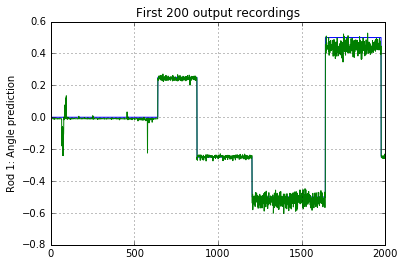

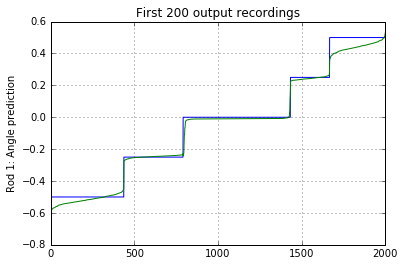

Updated lr to 0.000010
Epoch 61/61
3897/3897 [==============================] - 256s - loss: 0.0086 - mse: 0.0086 - val_loss: 7.4868e-04 - val_mse: 7.4868e-04
Wrote model to .\RodAngle\angle_weights_60.hdf
Epoch 62/62
3897/3897 [==============================] - 255s - loss: 0.0085 - mse: 0.0085 - val_loss: 4.3631e-04 - val_mse: 4.3631e-04
Wrote model to .\RodAngle\angle_weights_61.hdf
Epoch 63/63
3897/3897 [==============================] - 255s - loss: 0.0091 - mse: 0.0091 - val_loss: 5.9308e-04 - val_mse: 5.9308e-04
Wrote model to .\RodAngle\angle_weights_62.hdf
Epoch 64/64
3897/3897 [==============================] - 255s - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0021 - val_mse: 0.0021
Wrote model to .\RodAngle\angle_weights_63.hdf
Epoch 65/65
3897/3897 [==============================] - 255s - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0017 - val_mse: 0.0017
Wrote model to .\RodAngle\angle_weights_64.hdf
Epoch 66/66
3897/3897 [==============================] - 255s - loss: 0.0087 -

AssertionError: 

In [14]:

lr = 0.0001
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,60):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break

# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")        

lr = 0.00001
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,300):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break

Predicted.
array([[ 0. ],
       [ 0. ],
       [ 0. ],
       ..., 
       [ 0.5],
       [ 0.5],
       [ 0.5]], dtype=float32)
array([[-0.01090559],
       [-0.00516437],
       [-0.0193336 ],
       ..., 
       [ 0.39560071],
       [ 0.37355471],
       [ 0.35544991]], dtype=float32)


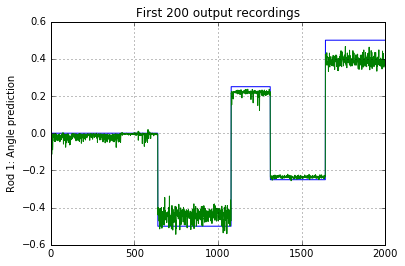

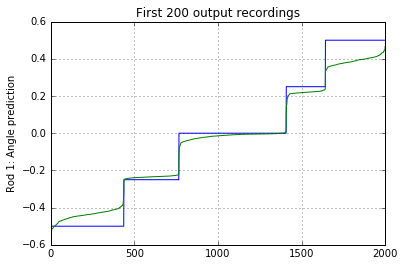

In [15]:
# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")        

Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
added 3204 new frames for a total of 3204
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk1.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk1.avi
added 2763 new frames for a total of 5967
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk2.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk2.avi
added 2355 new frames for a total of 8322
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
added 1667 new frames for a total of 9989
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk4.avi
.\..\..\TrainingData\Processed\RodTrainingDataAn

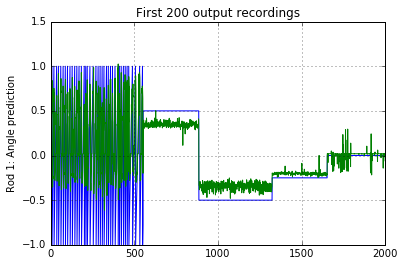

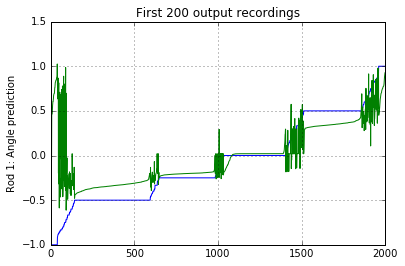

Updated lr to 0.000010
Epoch 176/176
3897/3897 [==============================] - 261s - loss: 0.0274 - mse: 0.1505 - val_loss: 0.0283 - val_mse: 0.1144
Wrote model to .\RodAngle\angle_weights_175.hdf
Epoch 177/177
3897/3897 [==============================] - 282s - loss: 0.0263 - mse: 0.1479 - val_loss: 0.0241 - val_mse: 0.1023
Wrote model to .\RodAngle\angle_weights_176.hdf
Epoch 178/178
3897/3897 [==============================] - 268s - loss: 0.0261 - mse: 0.1476 - val_loss: 0.0270 - val_mse: 0.1181
Wrote model to .\RodAngle\angle_weights_177.hdf
Epoch 179/179
3897/3897 [==============================] - 265s - loss: 0.0250 - mse: 0.1599 - val_loss: 0.0115 - val_mse: 0.0115
Wrote model to .\RodAngle\angle_weights_178.hdf
Epoch 180/180
3897/3897 [==============================] - 278s - loss: 0.0257 - mse: 0.1501 - val_loss: 0.0088 - val_mse: 0.0088
Wrote model to .\RodAngle\angle_weights_179.hdf
Epoch 181/181
3897/3897 [==============================] - 278s - loss: 0.0249 - mse: 0

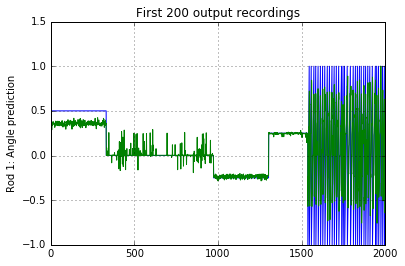

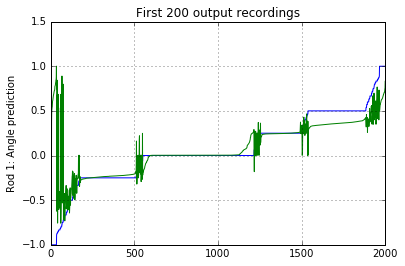

Updated lr to 0.000001
Epoch 201/201
 301/3897 [=>............................] - ETA: 255s - loss: 0.0246 - mse: 0.1381

In [ ]:


data_path  = ".\\..\\..\\TrainingData\\Processed\\RodTrainingDataAngles\\Result\\settings_full.tsv"
transformer = VideoTransform( zoom_range=0.1, rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [], data_format='channels_last' )
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2)

lr = 0.0001
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,175):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break

# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")        

lr = 0.00001
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,200):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break

# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")        

lr = 0.000001
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,300):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break

Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
added 3204 new frames for a total of 3204
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk1.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk1.avi
added 2763 new frames for a total of 5967
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk2.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk2.avi
added 2355 new frames for a total of 8322
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
added 1667 new frames for a total of 9989
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk4.avi
.\..\..\TrainingData\Processed\RodTrainingDataAn

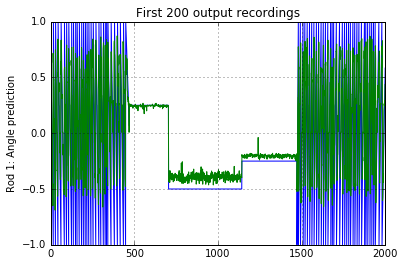

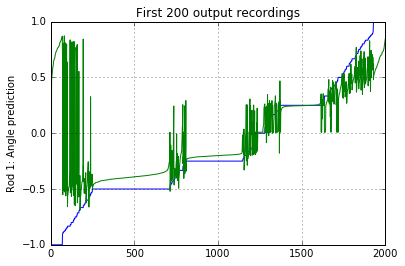

In [8]:
WEIGHTS_FNAME = '.\\RodAngle\\angle_weights_%i.hdf'
MODELS_FNAME = '.\\RodAngle\\angle_models_%i.h5'

data_path  = ".\\..\\..\\TrainingData\\Processed\\RodTrainingDataAngles\\Result\\settings_full.tsv"
transformer = VideoTransform( zoom_range=0.1, rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [], data_format='channels_last' )
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2)

batches_training_per_epoch = int(training.get_training_count() / batch_size)
batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )



# Load the best model result
epoch = 195
model.load_weights(WEIGHTS_FNAME % epoch, by_name=True)
print("Loaded model.")

# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")

In [11]:
def mse(y_true, y_pred):
    return K.square(y_pred - y_true)

def mse_wrap(y_true, y_pred):
    # This is a rapped MSE function, since -1 is the same as 1 for rod rotation.
    return K.square( K.min( K.abs( K.concatenate([y_pred - y_true, y_pred - y_true + 2, y_pred - y_true -2])), axis=1 ) )

lr = 0.000001
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,400):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break

Updated lr to 0.000001
Epoch 197/197
11996/11996 [==============================] - 826s - loss: 0.0244 - mse: 0.1534 - val_loss: 0.0274 - val_mse: 0.1167
Wrote model to .\RodAngle\angle_weights_196.hdf
Epoch 198/198
11996/11996 [==============================] - 820s - loss: 0.0230 - mse: 0.1531 - val_loss: 0.0258 - val_mse: 0.1166
Wrote model to .\RodAngle\angle_weights_197.hdf
Epoch 199/199
11996/11996 [==============================] - 819s - loss: 0.0230 - mse: 0.1538 - val_loss: 0.0265 - val_mse: 0.1182
Wrote model to .\RodAngle\angle_weights_198.hdf
Epoch 200/200
11996/11996 [==============================] - 820s - loss: 0.0239 - mse: 0.1530 - val_loss: 0.0260 - val_mse: 0.1158
Wrote model to .\RodAngle\angle_weights_199.hdf
Epoch 201/201
11996/11996 [==============================] - 824s - loss: 0.0241 - mse: 0.1562 - val_loss: 0.0261 - val_mse: 0.1206
Wrote model to .\RodAngle\angle_weights_200.hdf
Epoch 202/202
11996/11996 [==============================] - 833s - loss: 0.0

AssertionError: 

Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
added 3204 new frames for a total of 3204
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk1.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk1.avi
added 2763 new frames for a total of 5967
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk2.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk2.avi
added 2355 new frames for a total of 8322
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
added 1667 new frames for a total of 9989
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk4.avi
.\..\..\TrainingData\Processed\RodTrainingDataAn

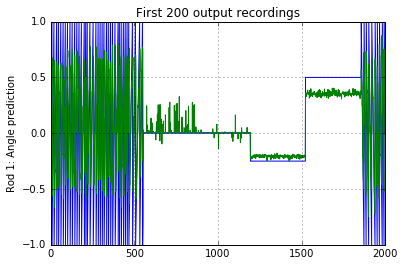

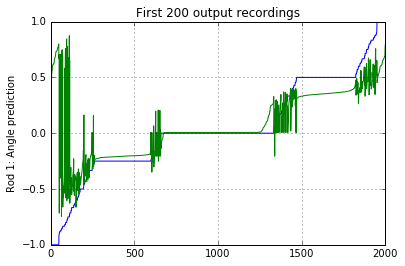

Updated lr to 0.000001
Epoch 204/204
11996/11996 [==============================] - 798s - loss: 0.0233 - mse: 0.1544 - val_loss: 0.0279 - val_mse: 0.1179
Wrote model to .\RodAngle\angle_weights_203.hdf
Epoch 205/205
11996/11996 [==============================] - 792s - loss: 0.0238 - mse: 0.1625 - val_loss: 0.0287 - val_mse: 0.1176
Wrote model to .\RodAngle\angle_weights_204.hdf
Epoch 206/206
11996/11996 [==============================] - 794s - loss: 0.0231 - mse: 0.1538 - val_loss: 0.0321 - val_mse: 0.1528
Wrote model to .\RodAngle\angle_weights_205.hdf
Epoch 207/207
11996/11996 [==============================] - 794s - loss: 0.0230 - mse: 0.1550 - val_loss: 0.0286 - val_mse: 0.1181
Wrote model to .\RodAngle\angle_weights_206.hdf
Epoch 208/208
11996/11996 [==============================] - 794s - loss: 0.0237 - mse: 0.1619 - val_loss: 0.0272 - val_mse: 0.1145
Wrote model to .\RodAngle\angle_weights_207.hdf
Epoch 209/209
11996/11996 [==============================] - 821s - loss: 0.0

In [ ]:
WEIGHTS_FNAME = '.\\RodAngle\\angle_weights_%i.hdf'
MODELS_FNAME = '.\\RodAngle\\angle_models_%i.h5'

data_path  = ".\\..\\..\\TrainingData\\Processed\\RodTrainingDataAngles\\Result\\settings_full.tsv"
transformer = VideoTransform( zoom_range=0.1, rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [], data_format='channels_last' )
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2)

batches_training_per_epoch = int(training.get_training_count() / batch_size)
batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )



# Load the best model result
epoch = 202
model.load_weights(WEIGHTS_FNAME % epoch, by_name=True)
print("Loaded model.")

# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")

def mse(y_true, y_pred):
    return K.square(y_pred - y_true)

def mse_wrap(y_true, y_pred):
    # This is a rapped MSE function, since -1 is the same as 1 for rod rotation.
    return K.square( K.min( K.abs( K.concatenate([y_pred - y_true, y_pred - y_true + 2, y_pred - y_true -2])), axis=1 ) )

lr = 0.000001
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,400):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break